In [1]:
import pandas as pd
import numpy as np
import os
import folium
from folium import plugins
import webbrowser
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
from scipy.stats import geom
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [2]:
sp_data = pd.read_csv('singapore_listings.csv')
print(sp_data.shape)
sp_data.head()

(7907, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [4]:
def fitting_freq_curve(price, xlabel, ylabel, bins, x_min=min, x_max=max, func='Gamma'):
    n, bins, patches = plt.hist(price,bins,density=True)
    if func == 'Gamma':
        xt = plt.xticks()[0]  
        xmin, xmax = min(xt), max(xt)  
        lnspc = np.linspace(xmin, xmax, len(price))

        ag, bg, cg = stats.gamma.fit(price) 
        pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
        plt.plot(lnspc, pdf_gamma, label="Gamma", color='r')

    xmin1 = x_min if type(x_min) in [int,float] else x_min(price)
    xmax1 = x_max if type(x_max) in [int,float] else x_max(price)
    
    plt.xlim(xmin1,xmax1)
    plt.title('distribution of '+xlabel+' '+ylabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [5]:
def filter_abnormal(sp_data):
    price = sp_data['price'].values
    pos = np.where(price > 500)
    sp_data = sp_data.drop(pos[0])
    return sp_data

In [7]:
def calculate_distribution(price):
    mean_price = np.mean(price)
    print(f'mean value: {mean_price}')
    over_price = sum(price>mean_price)/len(price)
    lower_price = sum(price<=mean_price)/len(price)
    print(f'over average percentage: {round(over_price*100,2)}%')
    print(f'lower average percentage: {round(lower_price*100,2)}%')

mean value: 169.33299607942328
over average percentage: 30.9%
lower average percentage: 69.1%


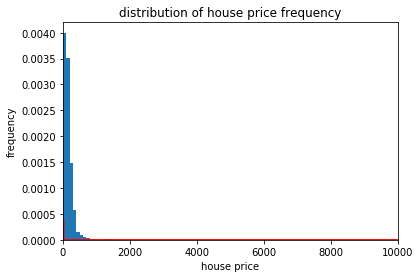

In [8]:
price = sp_data['price'].values
calculate_distribution(price)
fitting_freq_curve(price, 'house price', 'frequency', 100)

In [9]:
price = sp_data['price'].values
print(f'maximum of price: {max(price)}, <= 98% price value: {sorted(price)[round(len(price)*0.98)]}')

maximum of price: 10000, <= 98% price value: 581


In [10]:
sp_data = filter_abnormal(sp_data) # filter abnormal datapoints
sp_data.shape

(7709, 16)

## Feature frequency and its domestic distribution

mean value: 140.61512517836294
over average percentage: 39.45%
lower average percentage: 60.55%


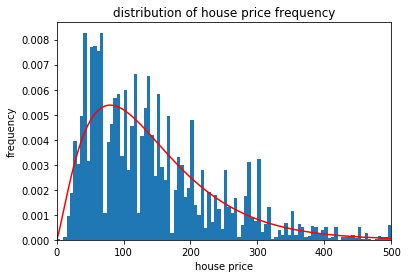

In [11]:
price = sp_data['price'].values
lat = sp_data['latitude'].values
lon = sp_data['longitude'].values
mn = sp_data['minimum_nights'].values
avl = sp_data['availability_365'].values
host = sp_data['calculated_host_listings_count'].values

calculate_distribution(price)
fitting_freq_curve(price, 'house price', 'frequency', 100)

mean value: 1.3143900492930343
over average percentage: 38.75%
lower average percentage: 61.25%


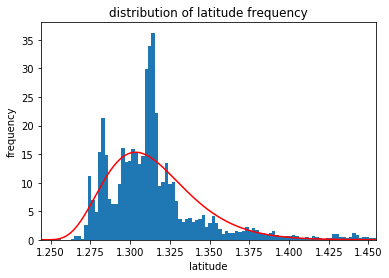

In [12]:
calculate_distribution(lat)
fitting_freq_curve(lat, 'latitude', 'frequency',100)

mean value: 103.84890921131147
over average percentage: 51.24%
lower average percentage: 48.76%


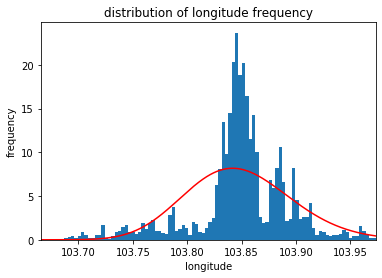

In [13]:
calculate_distribution(lon)
fitting_freq_curve(lon, 'longitude', 'frequency',100)

##### the first three can nearly be regarded as Poisson distribution

Text(0.5, 1.0, 'domesitc distribution of price')

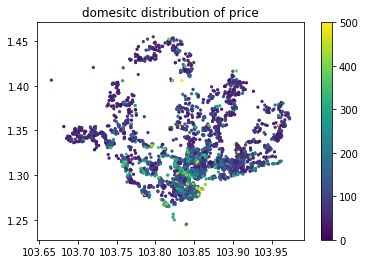

In [14]:
plt.scatter(lon, lat, c=price, s=5)
plt.colorbar()
plt.title('domesitc distribution of price')

mean value: 17.516409391620183
over average percentage: 21.84%
lower average percentage: 78.16%


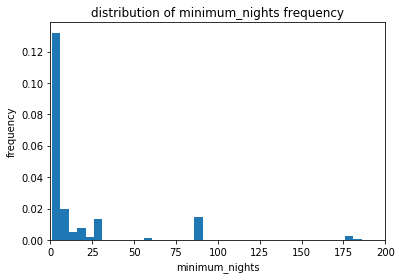

In [15]:
calculate_distribution(mn)
fitting_freq_curve(mn, 'minimum_nights', 'frequency',200,x_min=0,x_max=200,func=None)

Text(0.5, 1.0, 'domesitc distribution of minimum_nights')

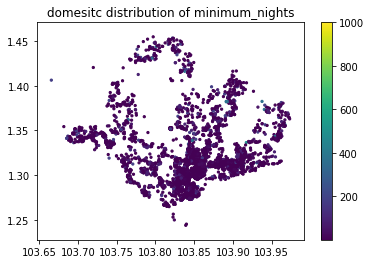

In [16]:
plt.scatter(lon, lat, c=mn, s=5)
plt.colorbar()
plt.title('domesitc distribution of minimum_nights')

mean value: 207.61019587495136
over average percentage: 54.91%
lower average percentage: 45.09%


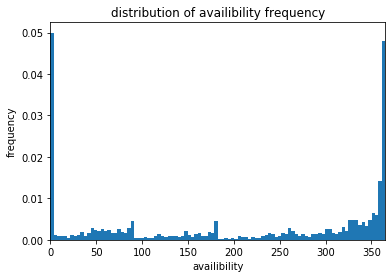

In [17]:
calculate_distribution(avl)
fitting_freq_curve(avl, 'availibility', 'frequency',100,func=None)

Text(0.5, 1.0, 'domesitc distribution of availibility_365')

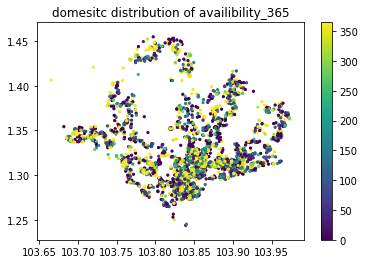

In [18]:
plt.scatter(lon, lat, c=avl, s=5)
plt.colorbar()
plt.title('domesitc distribution of availibility_365')

mean value: 40.90789985730964
over average percentage: 28.01%
lower average percentage: 71.99%


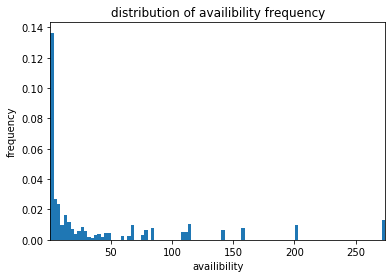

In [19]:
calculate_distribution(host)
fitting_freq_curve(host, 'availibility', 'frequency',100,func=None)

Text(0.5, 1.0, 'domesitc distribution of host_listings_count')

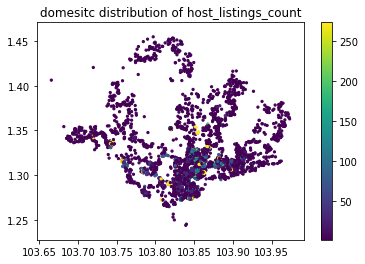

In [20]:
plt.scatter(lon, lat, c=host, s=5)
plt.colorbar()
plt.title('domesitc distribution of host_listings_count')

## Feature Correlation

In [21]:
sp_feature = sp_data[['latitude','longitude','calculated_host_listings_count','minimum_nights','availability_365','price']]
sp_feature.head()

,latitude,longitude,calculated_host_listings_count,minimum_nights,availability_365,price
0,1.44255,103.79580,2,180,365,83
1,1.33235,103.78521,1,90,365,81
2,1.44246,103.79667,2,6,365,69
3,1.34541,103.95712,9,1,353,206
4,1.34567,103.95963,9,1,355,94


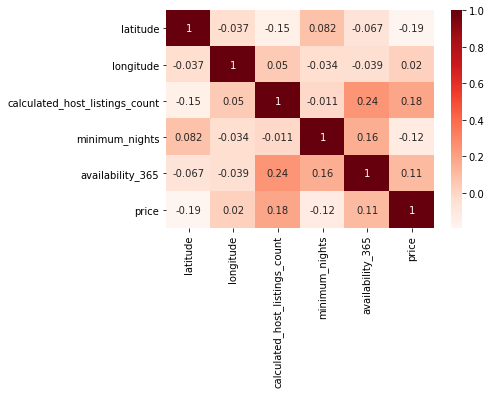

In [22]:
#plt.figure(figsize=(12,10))
cor = sp_feature.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [23]:
def separate_dict(f1_f2, bins=100):
    keys, values = [], []
    batch = len(f1_f2)//bins
    f1, f2 = f1_f2.keys(), f1_f2.values()
    f1_sort = sorted(f1)
    for i in range(bins):
        f1_gap = f1_sort[i*batch:(i+1)*batch]
        f2_gap = [f1_f2[x] for x in f1_gap]
        keys.append(np.mean(f1_gap))
        values.append(np.mean(f2_gap))
        
    return keys, values

In [24]:
def average_dict(f1_f2):
    average_f1_f2 = defaultdict(int)
    for f1 in f1_f2.keys():
        average_f1_f2[f1] = np.mean(f1_f2[f1])
        
    return average_f1_f2

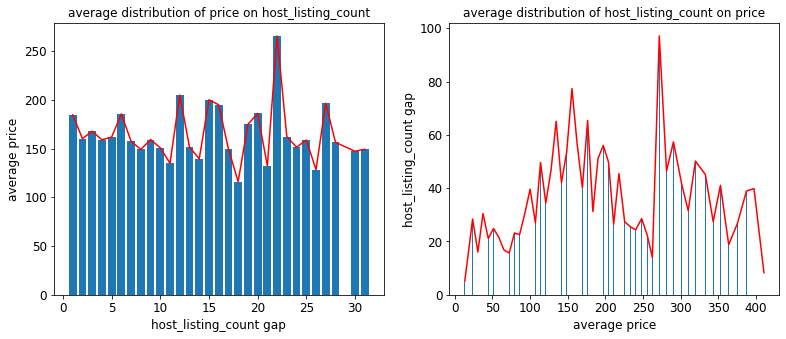

In [25]:
# average to ensure one x exactly correspond to one y
host_price = sp_data.groupby(['calculated_host_listings_count']).price.unique().agg(dict)
host_price_average = average_dict(host_price)
price_host = sp_data.groupby(['price']).calculated_host_listings_count.unique().agg(dict)
price_host_average = average_dict(price_host)
    
fig = plt.figure(figsize=(13,5)) # create the canvas for plotting
plt.subplot(1,2,1) 

ave_host1, ave_price1 = separate_dict(host_price_average, bins=30)
#ax1.figure()
plt.bar(ave_host1, ave_price1)
plt.plot(ave_host1, ave_price1,color='r')
plt.title('average distribution of price on host_listing_count')
plt.xlabel('host_listing_count gap',fontsize=12)
x = plt.xticks(fontsize=12)
plt.ylabel('average price',fontsize=12)
y = plt.yticks(fontsize=12)

plt.subplot(1,2,2) 
ave_price2, ave_host2 = separate_dict(price_host_average, bins=50)
plt.bar(ave_price2, ave_host2)
plt.plot(ave_price2,ave_host2, color='r')
plt.title('average distribution of host_listing_count on price')
plt.ylabel('host_listing_count gap',fontsize=12)
y = plt.yticks(fontsize=12)
plt.xlabel('average price',fontsize=12)
x = plt.xticks(fontsize=12)

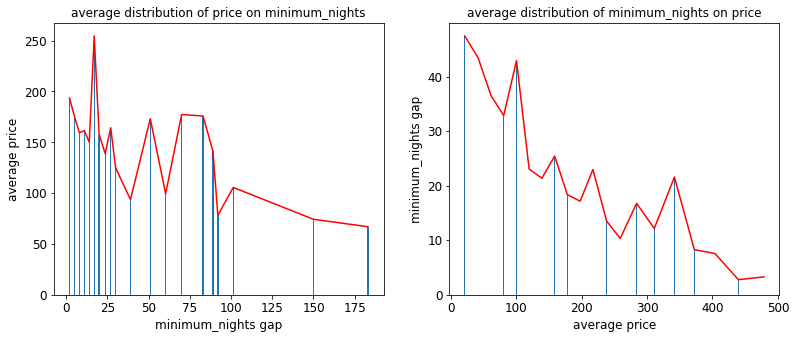

In [26]:
# average to ensure one x exactly correspond to one y
mn_price = sp_data.groupby(['minimum_nights']).price.unique().agg(dict)
mn_price_average = average_dict(mn_price)
price_mn = sp_data.groupby(['price']).minimum_nights.unique().agg(dict)
price_mn_average = average_dict(price_mn)
    
fig = plt.figure(figsize=(13,5)) # create the canvas for plotting
plt.subplot(1,2,1) 

ave_mn1, ave_price1 = separate_dict(mn_price_average, bins=20)
#ax1.figure()
plt.bar(ave_mn1, ave_price1)
plt.plot(ave_mn1, ave_price1,color='r')
plt.title('average distribution of price on minimum_nights')
plt.xlabel('minimum_nights gap',fontsize=12)
x = plt.xticks(fontsize=12)
plt.ylabel('average price',fontsize=12)
y = plt.yticks(fontsize=12)


plt.subplot(1,2,2) 
ave_price2, ave_mn2 = separate_dict(price_mn_average, bins=20)
plt.bar(ave_price2, ave_mn2)
plt.plot(ave_price2,ave_mn2, color='r')
plt.title('average distribution of minimum_nights on price')
plt.ylabel('minimum_nights gap',fontsize=12)
y = plt.yticks(fontsize=12)
plt.xlabel('average price',fontsize=12)
x = plt.xticks(fontsize=12)

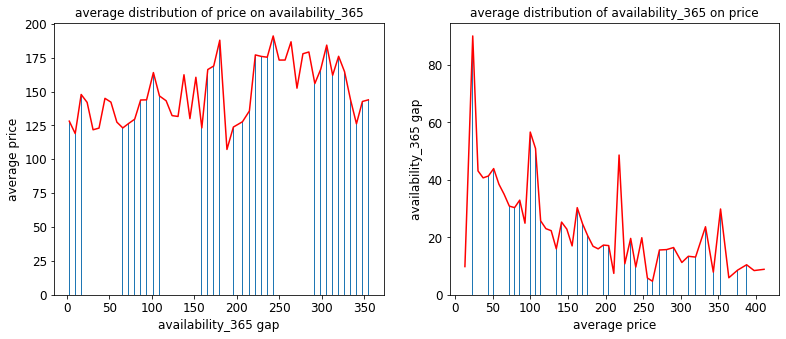

In [27]:
# average to ensure one x exactly correspond to one y
avl_price = sp_data.groupby(['availability_365']).price.unique().agg(dict)
avl_price_average = average_dict(avl_price)
price_avl = sp_data.groupby(['price']).availability_365.unique().agg(dict)
price_avl_average = average_dict(price_avl)
    
fig = plt.figure(figsize=(13,5)) # create the canvas for plotting
plt.subplot(1,2,1) 

ave_avl1, ave_price1 = separate_dict(avl_price_average, bins=50)
plt.bar(ave_avl1, ave_price1)
plt.plot(ave_avl1, ave_price1,color='r')
plt.title('average distribution of price on availability_365')
plt.xlabel('availability_365 gap',fontsize=12)
x = plt.xticks(fontsize=12)
plt.ylabel('average price',fontsize=12)
y = plt.yticks(fontsize=12)

plt.subplot(1,2,2) 
ave_price2, ave_avl2 = separate_dict(price_mn_average, bins=50)
plt.bar(ave_price2, ave_avl2)
plt.plot(ave_price2,ave_avl2, color='r')
plt.title('average distribution of availability_365 on price')
plt.ylabel('availability_365 gap',fontsize=12)
y = plt.yticks(fontsize=12)
plt.xlabel('average price',fontsize=12)
x = plt.xticks(fontsize=12)

## Pretrain and evaulate the model

In [28]:
def segment_position(pos_min_nights, pos_host_own, pos_avail, pos_price, lat_bins, lon_bins):
    keys, gmn, gho, ga, values = [], [], [], [], []
    lat, lon = sorted([x[0] for x in pos_price.keys()]), sorted([x[1] for x in pos_price.keys()])
    batch_lat, batch_lon = len(pos_price)//lat_bins, len(pos_price)//lon_bins
    for i in tqdm_notebook(range(lat_bins)):
        lat_gap = lat[i*batch_lat: (i+1)*batch_lat]
        ave_lat = np.mean(lat_gap)
        for j in range(lon_bins):
            lon_gap = lon[j*batch_lon: (j+1)*batch_lon]
            ave_lon = np.mean(lon_gap)
            ave_values, ave_pmn, ave_pnr, ave_par, ave_pho, ave_pa = [], [], [], [], [], []
            for m in range(batch_lat):
                for n in range(batch_lon):
                    if (lat_gap[m], lon_gap[n]) in pos_price.keys():
                        price_list = pos_price[(lat_gap[m], lon_gap[n])]
                        pmn = pos_min_nights[(lat_gap[m], lon_gap[n])]
                        pho = pos_host_own[(lat_gap[m], lon_gap[n])]
                        pa = pos_avail[(lat_gap[m], lon_gap[n])]
                        if len(price_list) == 1:
                            price = int(price_list)
                            min_nights = int(pmn)
                            host_own = int(pho)
                            avail = int(pa)
                        else:
                            price = int(np.mean(price))
                            min_nights = int(np.mean(pmn))
                            host_own = int(np.mean(pho))
                            avail = int(np.mean(pa))

                        ave_values.append(price)
                        ave_pmn.append(min_nights)
                        ave_pho.append(host_own)
                        ave_pa.append(avail)
            if ave_values != []:
                values.append(np.mean(ave_values))
                gmn.append(np.mean(ave_pmn))
                gho.append(np.mean(ave_pho))
                ga.append(np.mean(ave_pa))
                keys.append([ave_lat, ave_lon])
    return keys, gmn, gho, ga, values    

In [29]:
def get_pos_price(sp_data):
    lat = sp_data['latitude'].values
    lon = sp_data['longitude'].values
    min_nights = sp_data['minimum_nights'].values
    host_own = sp_data['calculated_host_listings_count'].values
    avail = sp_data['availability_365'].values
    price = sp_data['price'].values
    pos_price = sp_data.groupby(['latitude','longitude']).price.unique().agg(dict)
    X_cor = np.array(list(zip(lat,lon)))
    pos_min_nights = sp_data.groupby(['latitude','longitude']).minimum_nights.unique().agg(dict)
    pos_host_own = sp_data.groupby(['latitude','longitude']).calculated_host_listings_count.unique().agg(dict)
    pos_avail = sp_data.groupby(['latitude','longitude']).availability_365.unique().agg(dict)
    y = price.copy()
    
    return X_cor, y, pos_min_nights, pos_host_own, pos_avail, pos_price

In [30]:
from scipy.spatial import cKDTree
from scipy import inf
from collections import defaultdict

class PointPrediction:
    def __init__(self, r0, coordinate, cor_price):
        self.r = r0
        self.grid_cor = coordinate
        self.grid_price = cor_price
        
    def get_nearest_grid(self, X):
        nearest_grid = defaultdict(int)
        for point in X:
            grid_dis = np.linalg.norm(self.grid_cor-point,axis=1)
            grid_index = np.argmin(grid_dis)
            nearest_grid[str(point)] = grid_index
        return nearest_grid
        
    def score(self, X, y):
        tree = cKDTree(X)
        nearest_grid_train = self.get_nearest_grid(X)
        predict = []
        
        for point in X:
            grid_index = nearest_grid_train[str(point)]
            predict.append(self.grid_price[grid_index])
                
        MSE = ((np.array(predict)-y)**2).mean()    
        return predict, MSE

In [32]:
class TrainRegressor:
    def __init__(self, lr, lamda, max_epoch, seg_part):
        self.lr = lr
        self.p = lamda
        self.epo = max_epoch
        self.seg = seg_part
        self.lnr()
        self.svm()
        self.rf()
        self.mlp()
        
    def lnr(self):
        self.clf1 = LinearRegression()
        
    def svm(self):
        self.clf2 = SVR(kernel = 'sigmoid', C=1.0, epsilon=0.2)
        
    def rf(self):
        self.clf3 = RandomForestRegressor(random_state=4)
        
    def mlp(self):
        self.clf4 = MLPRegressor(hidden_layer_sizes = (100,3), learning_rate = 'adaptive')  
        
    def fit_models(self, X ,y):
        self.clf.fit(X, y)
        
    def predict(self, X_test, y_test):
        y_pred = self.clf.predict(X_test)
        return y_pred
        
    def get_data(self, Xcor, pmn, gmn, pho, gho, pa, ga, nearest_grid, predict_price):
        self.ave = predict_price.copy()
        X = []
        for i in range(len(Xcor)):
            point = tuple(Xcor[i])
            grid_index = nearest_grid[str(point)]
            ave = predict_price[i]
            min_nights = pmn[point][0]-gmn[grid_index]
            hoster = pho[point][0]-gho[grid_index]
            avail = pa[point][0]-ga[grid_index]
            X.append([ave, min_nights, hoster, avail])
        X = np.array(X)
        return X
    
    def fit(self, train_sp, test_sp, record_metrics):
        self.mse_test = []
        Xcor_train, y_train, pmn_train, pho_train, pa_train, pos_price_train = get_pos_price(train_sp)
        coordinate, gmn, gho, ga, cor_price = segment_position(pmn_train, pho_train, pa_train, 
                                                               pos_price_train, self.seg, self.seg)
        pospre = PointPrediction(0.03, coordinate, cor_price)
        nearest_grid_train = pospre.get_nearest_grid(Xcor_train)
        predict_price_train, mse_train = pospre.score(Xcor_train, y_train)

        Xtrain = self.get_data(Xcor_train, pmn_train, gmn, pho_train, gho, pa_train, ga, nearest_grid_train, 
                               predict_price_train)
        
        Xcor_test, y_test, pmn_test, pho_test, pa_test, pos_price_test = get_pos_price(test_sp)
        nearest_grid_test = pospre.get_nearest_grid(Xcor_test)
        predict_price_test, mse_test = pospre.score(Xcor_test, y_test)
        
        Xtest = self.get_data(Xcor_test, pmn_test, gmn, pho_test, gho, pa_test, ga, nearest_grid_test, predict_price_test)
        
        self.clf = self.clf1
        self.fit_models(Xcor_train, y_train)
        y_pred = self.predict(Xcor_test, y_test)
        print(f'baseline test mse: {mse(y_test, y_pred)}, baseline test R2: {r2_score(y_test, y_pred)}')
        record_metrics['baseline mse'].append(mse(y_test, y_pred)) 
        record_metrics['baseline R2'].append(r2_score(y_test, y_pred))
        
        print(f'initial test mse: {mse_test}, initial test R2: {r2_score(y_test, predict_price_test)}\n')
        record_metrics['strong baseline mse'].append(mse_test) 
        record_metrics['strong baseline R2'].append(r2_score(y_test, predict_price_test))
        
        clf = [self.clf1, self.clf2, self.clf3, self.clf4]
        names = ["Linear Regression", "SVM", "Random Forest", "Multi-layer Perceptron"]
        for i in range(len(clf)):
            self.clf = clf[i]
            self.fit_models(coordinate, cor_price)
            y_pred = self.predict(Xcor_test, y_test)
            if i == 0:
                record_metrics['LR mse'].append(mse(y_test, y_pred)) 
                record_metrics['LR R2'].append(r2_score(y_test, y_pred))
            elif i == 1:
                record_metrics['SVM mse'].append(mse(y_test, y_pred)) 
                record_metrics['SVM R2'].append(r2_score(y_test, y_pred))
            elif i == 2:
                record_metrics['RF mse'].append(mse(y_test, y_pred)) 
                record_metrics['RF R2'].append(r2_score(y_test, y_pred))
            else:
                record_metrics['MLP mse'].append(mse(y_test, y_pred)) 
                record_metrics['MLP R2'].append(r2_score(y_test, y_pred))
                
            print(f'Model: {names[i]}, test MSE: {mse(y_test, y_pred)}, test R2: {r2_score(y_test, y_pred)}')
    
        self.mn_bias = defaultdict(int)
        self.ho_bias = defaultdict(int)
        self.av_bias = defaultdict(int)
        
        for e in range(self.epo):
            for i in range(len(Xtrain)):
                point = str(Xcor_train[i])
                ave, mb, hb, av = Xtrain[i][0], Xtrain[i][1], Xtrain[i][2], Xtrain[i][3]
                grid_index = nearest_grid_train[point]
                diff = ave+self.mn_bias[grid_index]*mb+self.ho_bias[grid_index]*hb+self.av_bias[grid_index]*av-y_train[i] 
                
                self.mn_bias[grid_index] -= self.lr*(2*mb*diff + self.p*self.mn_bias[grid_index])
                self.ho_bias[grid_index] -= self.lr*(2*hb*diff + self.p*self.ho_bias[grid_index])
                self.av_bias[grid_index] -= self.lr*(2*av*diff + self.p*self.av_bias[grid_index])
                
            MSE_test, self.test_predict = self.mse(Xtest, Xcor_test, nearest_grid_test, y_test)
            hlr_r2 = r2_score(y_test, self.test_predict)
            
            if self.mse_test != [] and MSE_test > self.mse_test[-1]:
                print(f'Model: Hierarchical LinearRegressor, test MSE: {MSE_test}, test R2: {hlr_r2}')
                break
            self.mse_test.append(MSE_test)
        
        record_metrics['HLR mse'].append(MSE_test) 
        record_metrics['HLR R2'].append(hlr_r2)       
            
    def mse(self, X, Xcor, nearest_grid, y):
        predict = []
        for i in range(len(X)):
            point = str(Xcor[i])
            ave, mb, hb, av = X[i][0], X[i][1], X[i][2], X[i][3]
            grid_index = nearest_grid[point]
            res = ave+self.mn_bias[grid_index]*mb+self.ho_bias[grid_index]*hb+self.av_bias[grid_index]*av
            predict.append(res)
            
        MSE = ((np.array(predict)-y)**2).mean() 
        return MSE, predict

In [141]:
import warnings
warnings.filterwarnings("ignore")
record_metrics = defaultdict(list)

for i in range(10):
    train_sp, test_sp = train_test_split(sp_data, test_size=1/20)   
    lr = 1.0e-6
    max_epoch = 20
    lamda = 10
    seg_part = 50
    lrg = TrainRegressor(lr, lamda, max_epoch, seg_part)
    lrg.fit(train_sp, test_sp, record_metrics)
    


baseline test mse: 8222.86285017032, baseline test R2: 0.04536479392168147
initial test mse: 8064.036711697855, initial test R2: 0.0638037520064737

Model: Linear Regression, test MSE: 8212.395559255847, test R2: 0.046579996534359625
Model: SVM, test MSE: 8948.697512953368, test R2: -0.03890115280638895
Model: Random Forest, test MSE: 7522.150468045639, test R2: 0.12671416353902454
Model: Multi-layer Perceptron, test MSE: 8615.603010950626, test R2: -0.00023046786892133575
Model: Hierarchical LinearRegressor, test MSE: 7741.859082656166, test R2: 0.10120703999730607



baseline test mse: 9417.927382261845, baseline test R2: 0.018606343512428736
initial test mse: 9080.220034182425, initial test R2: 0.05379708513766179

Model: Linear Regression, test MSE: 9502.754419336294, test R2: 0.00976695532174332
Model: SVM, test MSE: 9820.346231627365, test R2: -0.02332765002867454
Model: Random Forest, test MSE: 8136.818166209944, test R2: 0.15210412990108857
Model: Multi-layer Perceptron, test MSE: 29582.02296856123, test R2: -2.0825900974873814
Model: Hierarchical LinearRegressor, test MSE: 8942.713421621029, test R2: 0.06812594028970043



baseline test mse: 7834.637188542572, baseline test R2: 0.043847911764259284
initial test mse: 7278.0619658394535, initial test R2: 0.11177327303384177

Model: Linear Regression, test MSE: 7941.071625581487, test R2: 0.030858476926896472
Model: SVM, test MSE: 8256.752857706308, test R2: -0.0076677830707445604
Model: Random Forest, test MSE: 6827.602335698448, test R2: 0.1667481117736741
Model: Multi-layer Perceptron, test MSE: 8246.23897565287, test R2: -0.006384651505244587
Model: Hierarchical LinearRegressor, test MSE: 6973.809514542553, test R2: 0.1489047457054551



baseline test mse: 7523.548123997034, baseline test R2: 0.006757341220880453
initial test mse: 7391.448991971169, initial test R2: 0.02419678481230103

Model: Linear Regression, test MSE: 7810.687752105732, test R2: -0.031150215554607286
Model: SVM, test MSE: 7580.545204833147, test R2: -0.0007672909313005682
Model: Random Forest, test MSE: 6592.583233931353, test R2: 0.12966132580356915
Model: Multi-layer Perceptron, test MSE: 24254.89830162565, test R2: -2.2020795614616193
Model: Hierarchical LinearRegressor, test MSE: 6807.021360284152, test R2: 0.10135166508871052



baseline test mse: 8545.79281147468, baseline test R2: 0.04853070509834856
initial test mse: 7575.21382361369, initial test R2: 0.15659278027368806

Model: Linear Regression, test MSE: 8457.841278043223, test R2: 0.05832303043850673
Model: SVM, test MSE: 9274.76383419689, test R2: -0.03263128423304873
Model: Random Forest, test MSE: 7249.8047465537265, test R2: 0.19282309288893307
Model: Multi-layer Perceptron, test MSE: 8991.941862544341, test R2: -0.0011425238702158502
Model: Hierarchical LinearRegressor, test MSE: 7252.799207865468, test R2: 0.19248969632108415



baseline test mse: 8825.252330391726, baseline test R2: 0.06230670507639935
initial test mse: 9050.257098208624, initial test R2: 0.038399687553379636

Model: Linear Regression, test MSE: 8909.586347755407, test R2: 0.05334611792768229
Model: SVM, test MSE: 9663.05524117326, test R2: -0.026710825810726035
Model: Random Forest, test MSE: 8281.600305494843, test R2: 0.12007036320568687
Model: Multi-layer Perceptron, test MSE: 9413.09300576175, test R2: -0.0001520484121104726
Model: Hierarchical LinearRegressor, test MSE: 8762.179211797456, test R2: 0.06900829707418232



baseline test mse: 7142.477267973991, baseline test R2: 0.06013919301505144
initial test mse: 7632.722416581478, initial test R2: -0.0043709459330543154

Model: Linear Regression, test MSE: 7254.1394173734825, test R2: 0.04544584868830792
Model: SVM, test MSE: 7604.181515544042, test R2: -0.0006153198001717097
Model: Random Forest, test MSE: 6534.527758006903, test R2: 0.1401377559234427
Model: Multi-layer Perceptron, test MSE: 7761.030464778922, test R2: -0.02125468265311814
Model: Hierarchical LinearRegressor, test MSE: 7355.564797078163, test R2: 0.03209953540770083



baseline test mse: 8374.742017179196, baseline test R2: 0.050099000488856404
initial test mse: 7082.748473825319, initial test R2: 0.19664273349893457

Model: Linear Regression, test MSE: 8446.665784554521, test R2: 0.041941082504244664
Model: SVM, test MSE: 8972.043609776489, test R2: -0.017649639248809468
Model: Random Forest, test MSE: 6285.956877941939, test R2: 0.2870184288671167
Model: Multi-layer Perceptron, test MSE: 8826.716419183009, test R2: -0.0011659740424405651



baseline test mse: 8008.942237502312, baseline test R2: 0.016015118394286598
initial test mse: 8141.6361769879495, initial test R2: -0.00028776236856553616

Model: Linear Regression, test MSE: 8064.954166765115, test R2: 0.009133449136380478
Model: SVM, test MSE: 8223.664038040279, test R2: -0.010365769270400449
Model: Random Forest, test MSE: 7161.398905207848, test R2: 0.12014495236641476
Model: Multi-layer Perceptron, test MSE: 26403.69643625117, test R2: -2.2439787104620508
Model: Hierarchical LinearRegressor, test MSE: 7601.96653562854, test R2: 0.06601647012704093



baseline test mse: 8881.563680423791, baseline test R2: 0.016182426398113847
initial test mse: 7919.20010168363, initial test R2: 0.12278417300787248

Model: Linear Regression, test MSE: 8845.059702843753, test R2: 0.020225999798231253
Model: SVM, test MSE: 9102.758134715024, test R2: -0.008319451778433962
Model: Random Forest, test MSE: 7230.40727833461, test R2: 0.19908227867537498
Model: Multi-layer Perceptron, test MSE: 9070.671772965123, test R2: -0.004765221048536716
Model: Hierarchical LinearRegressor, test MSE: 7755.096322415064, test R2: 0.14096207362854307


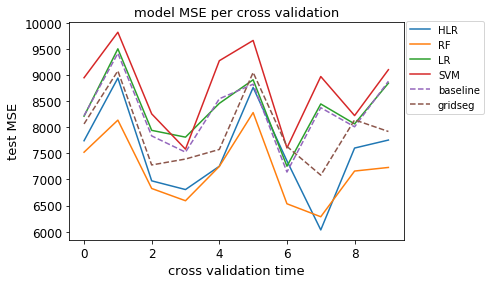

In [142]:
plt.plot(record_metrics['HLR mse'], label='HLR')
plt.plot(record_metrics['RF mse'], label='RF')
plt.plot(record_metrics['LR mse'], label='LR')
plt.plot(record_metrics['SVM mse'], label='SVM')

plt.plot(record_metrics['baseline mse'], label='baseline', linestyle='--')
plt.plot(record_metrics['strong baseline mse'], label='gridseg',linestyle='--')

plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))
plt.title('model MSE per cross validation',fontsize=13)
plt.xlabel('cross validation time',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('test MSE',fontsize=13)
y = plt.yticks(fontsize=12)

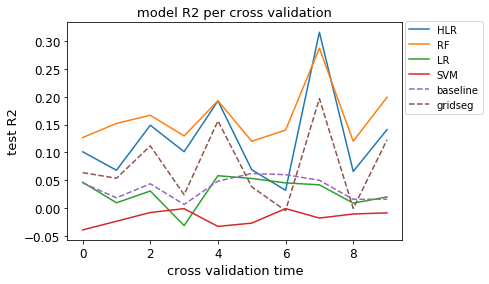

In [143]:
plt.plot(record_metrics['HLR R2'], label='HLR')
plt.plot(record_metrics['RF R2'], label='RF')
plt.plot(record_metrics['LR R2'], label='LR')
plt.plot(record_metrics['SVM R2'], label='SVM')

plt.plot(record_metrics['baseline R2'], label='baseline', linestyle='--')
plt.plot(record_metrics['strong baseline R2'], label='gridseg',linestyle='--')

plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))
plt.title('model R2 per cross validation',fontsize=13)
plt.xlabel('cross validation time',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('test R2',fontsize=13)
y = plt.yticks(fontsize=12)

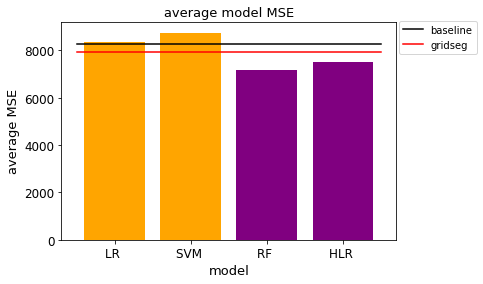

In [146]:
mse_average_list = []
model_list = []

for key in record_metrics.keys():
    if key.endswith('mse'):
        if key.startswith(('strong','baseline','MLP')) :
            continue
        mse_average_list.append(np.mean(record_metrics[key]))
        model_list.append(key.rstrip('mse'))
        
color_index = np.where(mse_average_list < np.mean(record_metrics['strong baseline mse']))[0]
color_control = np.array(['orange']*len(mse_average_list))
color_control[color_index] = 'purple'
color_control = tuple(list(color_control))
mean_baseline_mse = np.mean(record_metrics['baseline mse'])
mean_strong_mse = np.mean(record_metrics['strong baseline mse'])  

plt.bar(model_list,mse_average_list,color=color_control)
plt.plot(np.arange(-0.5,4.5),[mean_baseline_mse]*5,color='black',label='baseline')
plt.plot(np.arange(-0.5,4.5),[mean_strong_mse]*5,color='red',label='gridseg')
plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))              
plt.title('average model MSE',fontsize=13)
plt.xlabel('model',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('average MSE',fontsize=13)
y = plt.yticks(fontsize=12)

In [149]:
mse_model_ave_list = [mean_baseline_mse]+[mean_strong_mse]+mse_average_list
mse_model_ave_list = [round(x) for x in mse_model_ave_list]
print(f'average mse of models: {mse_model_ave_list}')

average mse of models: [8278.0, 7922.0, 8345.0, 8745.0, 7182.0, 7523.0]


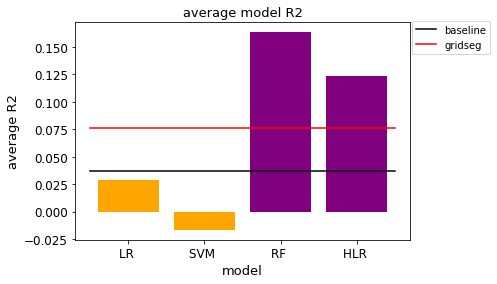

In [152]:
R2_average_list = []
model_list = []

for key in record_metrics.keys():
    if key.endswith('R2'):
        if key.startswith(('strong','baseline','MLP')):
            continue
        R2_average_list.append(np.mean(record_metrics[key]))
        model_list.append(key.rstrip('R2'))
               
color_index = np.where(R2_average_list > np.mean(record_metrics['strong baseline R2']))[0]
color_control = np.array(['orange']*len(R2_average_list))
color_control[color_index] = 'purple'
color_control = tuple(list(color_control))
mean_baseline_R2 = np.mean(record_metrics['baseline R2'])
mean_strong_R2 = np.mean(record_metrics['strong baseline R2'])  
        
plt.bar(model_list,R2_average_list,color=color_control)
plt.plot(np.arange(-0.5,4.5),[mean_baseline_R2]*5,color='black',label='baseline')
plt.plot(np.arange(-0.5,4.5),[mean_strong_R2]*5,color='red',label='gridseg')
plt.legend(loc='upper right',bbox_to_anchor=(1.255, 1.03))                 
plt.title('average model R2',fontsize=13)
plt.xlabel('model',fontsize=13)
x = plt.xticks(fontsize=12)
plt.ylabel('average R2',fontsize=13)
y = plt.yticks(fontsize=12)

In [157]:
R2_model_ave_list = [mean_baseline_R2]+[mean_strong_R2]+R2_average_list
R2_model_ave_list = [round(x,3) for x in R2_model_ave_list]
print(f'average mse of models: {R2_model_ave_list}')

average mse of models: [0.037, 0.076, 0.028, -0.017, 0.163, 0.124]
